In [1]:
import corner
import emcee
import time
import numpy as np

from joblib import load
from pathlib import Path
from multiprocessing import Pool
from scipy.optimize import minimize
from IPython.display import display, Math
from tensorflow.keras.models import load_model

from modules.network import r_squared

2024-02-21 18:49:01.053729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 18:49:01.053775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 18:49:01.055632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 18:49:01.066240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 18:49:02.331810: W tensorflow/compiler/tf2

In [2]:
data = 'models_0.5-20_100k_smooth_2'

cwd = Path.cwd()
result_path = cwd / 'results'
path_to_data = cwd / 'data' / data
target_file_path = cwd / 'data' / 'target'
mcmc_path = cwd / 'mcmc'
mcmc_path.mkdir(exist_ok=True)  # Create the directory if it doesn't exist'

path_to_results = cwd / 'results'
n_points = 2
result_dir = path_to_results / 'GRU' / f'100k_smooth_{n_points}' / '256x5'
model_file_path = result_dir / 'GRU_model.h5'

xd = np.load(target_file_path / 'energy_true.npy', allow_pickle=True)
yd = np.load(target_file_path / 'y_true.npy', allow_pickle=True)
yderr = np.load(target_file_path / 'yerr.npy', allow_pickle=True)

model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
flux_scaler = load(path_to_data / 'flux_scaler.joblib')

In [3]:
class Parameters:
    def __init__(self, nH=np.log10(1.0), Betor10=-2, Rin_M=10, Incl=30, rel_refl=-1, Fe_abund=1, log_xi=1, kTs=2, alpha=2, kTe=np.log10(40), norm=1, Tin=1, norm_disk=np.log10(1), f_true=0.2):
        # Parameters
        self.nH = nH
        self.Betor10 = Betor10
        self.Rin_M = Rin_M
        self.Incl = Incl
        self.rel_refl = rel_refl
        self.Fe_abund = Fe_abund
        self.log_xi = log_xi
        self.kTs = kTs
        self.alpha = alpha
        self.kTe = kTe
        self.norm = norm
        self.Tin = Tin
        self.norm_disk = norm_disk
        self.f_true = f_true
        
        # Ranges for each parameter (min, max)
        self.ranges = {
            'nH': (-2, 1),
            'Betor10': (-10, 0),
            'Rin_M': (6, 150),
            'Incl': (0, 90),
            'rel_refl': (-1, 0),
            'Fe_abund': (0.5, 3.0),
            'log_xi': (1, 4),
            'kTs': (0.15, 2.0),
            'alpha': (0.1, 3.0),
            'kTe': (np.log10(2), 3),
            'norm': (0.1, 1.0),
            'Tin': (0.1, 2.0),
            'norm_disk': (-1, 4),
            'f_true': (-2, 1)
        }

    def to_array(self):
        """ Convert parameters to an array. """
        return np.array([self.nH, self.Betor10, self.Rin_M, self.Incl, self.rel_refl, self.Fe_abund, self.log_xi, self.kTs, self.alpha, self.kTe, self.norm, self.Tin, self.norm_disk, self.f_true])

    def is_param_within_range(self, param_name):
        """ Check if a specific parameter is within its defined range. """
        if param_name in self.ranges:
            value = getattr(self, param_name)
            min_val, max_val = self.ranges[param_name]
            return min_val <= value <= max_val
        return True  # If the parameter is not in ranges, assume no range restriction
    
    def update_from_array(self, array):
        """ Update parameters from an array (e.g., the output of an optimization). """
        (self.nH, self.Betor10, self.Rin_M, self.Incl, self.rel_refl, 
         self.Fe_abund, self.log_xi, self.kTs, self.alpha, self.kTe, 
         self.norm, self.Tin, self.norm_disk, self.f_true) = array

    def __repr__(self):
        """ String representation for easy debugging, one parameter per line. """
        params_repr = '\n'.join([f'{key}={value}' for key, value in self.__dict__.items() if key != 'ranges'])
        return f'Parameters(\n{params_repr}\n)'

In [4]:
def Model(x, par):
    x_grid = (np.array(x).reshape(-1, n_points).mean(axis=1)).tolist()
    y_pred = model.predict(par.reshape(-1, par.shape[0]), verbose=0)
    y_pred_d = flux_scaler.inverse_transform(y_pred)

    return np.interp(x, x_grid, y_pred_d[0])

def log_likelihood(theta):
    model_par = theta[:-1].copy()
    log_f = theta[-1]
    model = Model(xd, model_par)
    sigma2 = yderr**2 + model**2 * np.exp(2 * log_f)
#    sigma2 = yerr**2 + np.exp(2 * log_f)
    return -0.5 * np.sum((yd - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(params):
    # Assuming params is an instance of Parameters class

    # Automatically check each parameter in the params object
    for param_name in params.__dict__:
        # Skip checking for attributes that are not parameters (like 'ranges')
        if param_name == 'ranges':
            continue

        if not params.is_param_within_range(param_name):
            return -np.inf

    # If all parameters are within range, return 0.0 or another suitable value
    return 0.0

def log_probability(theta):
    params = Parameters()
    params.update_from_array(theta)
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, None
    return lp + log_likelihood(theta), lp

In [5]:
# The "true" parameters.
params = Parameters(
    nH=np.log10(1.0), 
    Betor10=-2, 
    Rin_M=10, 
    Incl=30, 
    rel_refl=-0.5, 
    Fe_abund=1, 
    log_xi=2, 
    kTs=1, 
    alpha=2, 
    kTe=np.log10(40), 
    norm=0.5, 
    Tin=1, 
    norm_disk=np.log10(1), 
    f_true=np.log10(0.2))

par_original = params.to_array()


Maximum likelihood estimates:
Parameters(
nH=0.04967141530112327
Betor10=-2.0138264301171183
Rin_M=10.064768853810069
Incl=30.1523029856408
rel_refl=-0.5234153374723336
Fe_abund=0.976586304305082
log_xi=2.157921281550739
kTs=1.076743472915291
alpha=1.9530525614065049
kTe=1.656315995686559
norm=0.4536582307187538
Tin=0.9534270246429744
norm_disk=0.02419622715660341
f_true=-0.8902980288017985
)


Text(0, 0.5, 'y')

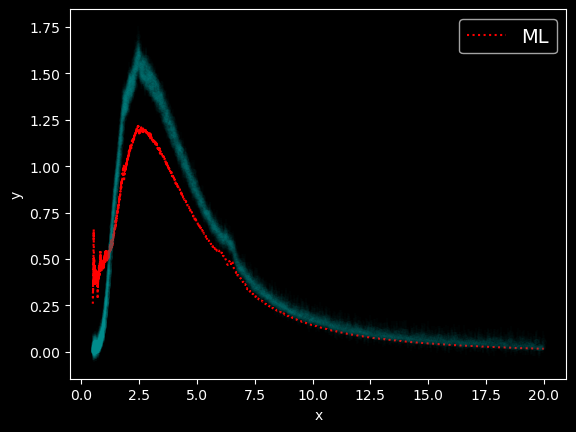

In [6]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = par_original + 0.1 * np.random.randn(14)
soln = minimize(nll, initial)
# Assuming soln is the result of your optimization process
params_ml = Parameters()
params_ml.update_from_array(soln.x)
par_ml = params_ml.to_array()

print("Maximum likelihood estimates:")
print(params_ml)

plt.errorbar(xd, yd, yerr=yderr, fmt=".c", capsize=0, alpha=0.02)
plt.plot(xd, Model(xd, par_ml[:-1]), ":r", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")

In [7]:
init = par_original

pos = init + 1e-1 * np.random.randn(256, len(init))
nwalkers, ndim = pos.shape
max_n = 5000

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(mcmc_path / filename)
backend.reset(nwalkers, ndim)

In [8]:
start_time = time.time()

print('start sampler')

'''with Pool() as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_probability, 
    moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ], 
    backend=backend, 
    blobs_dtype=float, 
    a=3.0)

    sampler.run_mcmc(pos, 1000, progress=True)'''

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_probability, 
    #moves=[
    #    (emcee.moves.DEMove(), 0.8),
    #    (emcee.moves.DESnookerMove(), 0.2),
    #], 
    backend=backend, 
    blobs_dtype=float, 
    #a=5.0
    )
sampler.run_mcmc(pos, max_n, progress=True)


print("--- %s seconds ---" % (time.time() - start_time))

start sampler


100%|██████████| 5000/5000 [13:39:15<00:00,  9.83s/it]  

--- 49176.82929158211 seconds ---


In [9]:
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for state, log_prob, blob, *_ in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

100%|██████████| 5000/5000 [14:34:49<00:00, 10.50s/it]  


Text(0, 0.5, 'mean $\\hat{\\tau}$')

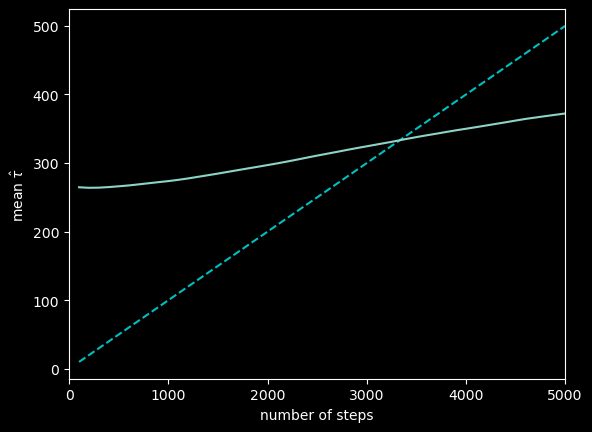

In [10]:
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 10.0, "--c")
plt.plot(n, y)
plt.xlim(0, n.max())
#plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

burn-in: 1049
thin: 92
flat chain shape: (24832, 14)
flat log prob shape: (24832,)
flat log prior shape: (24832,)


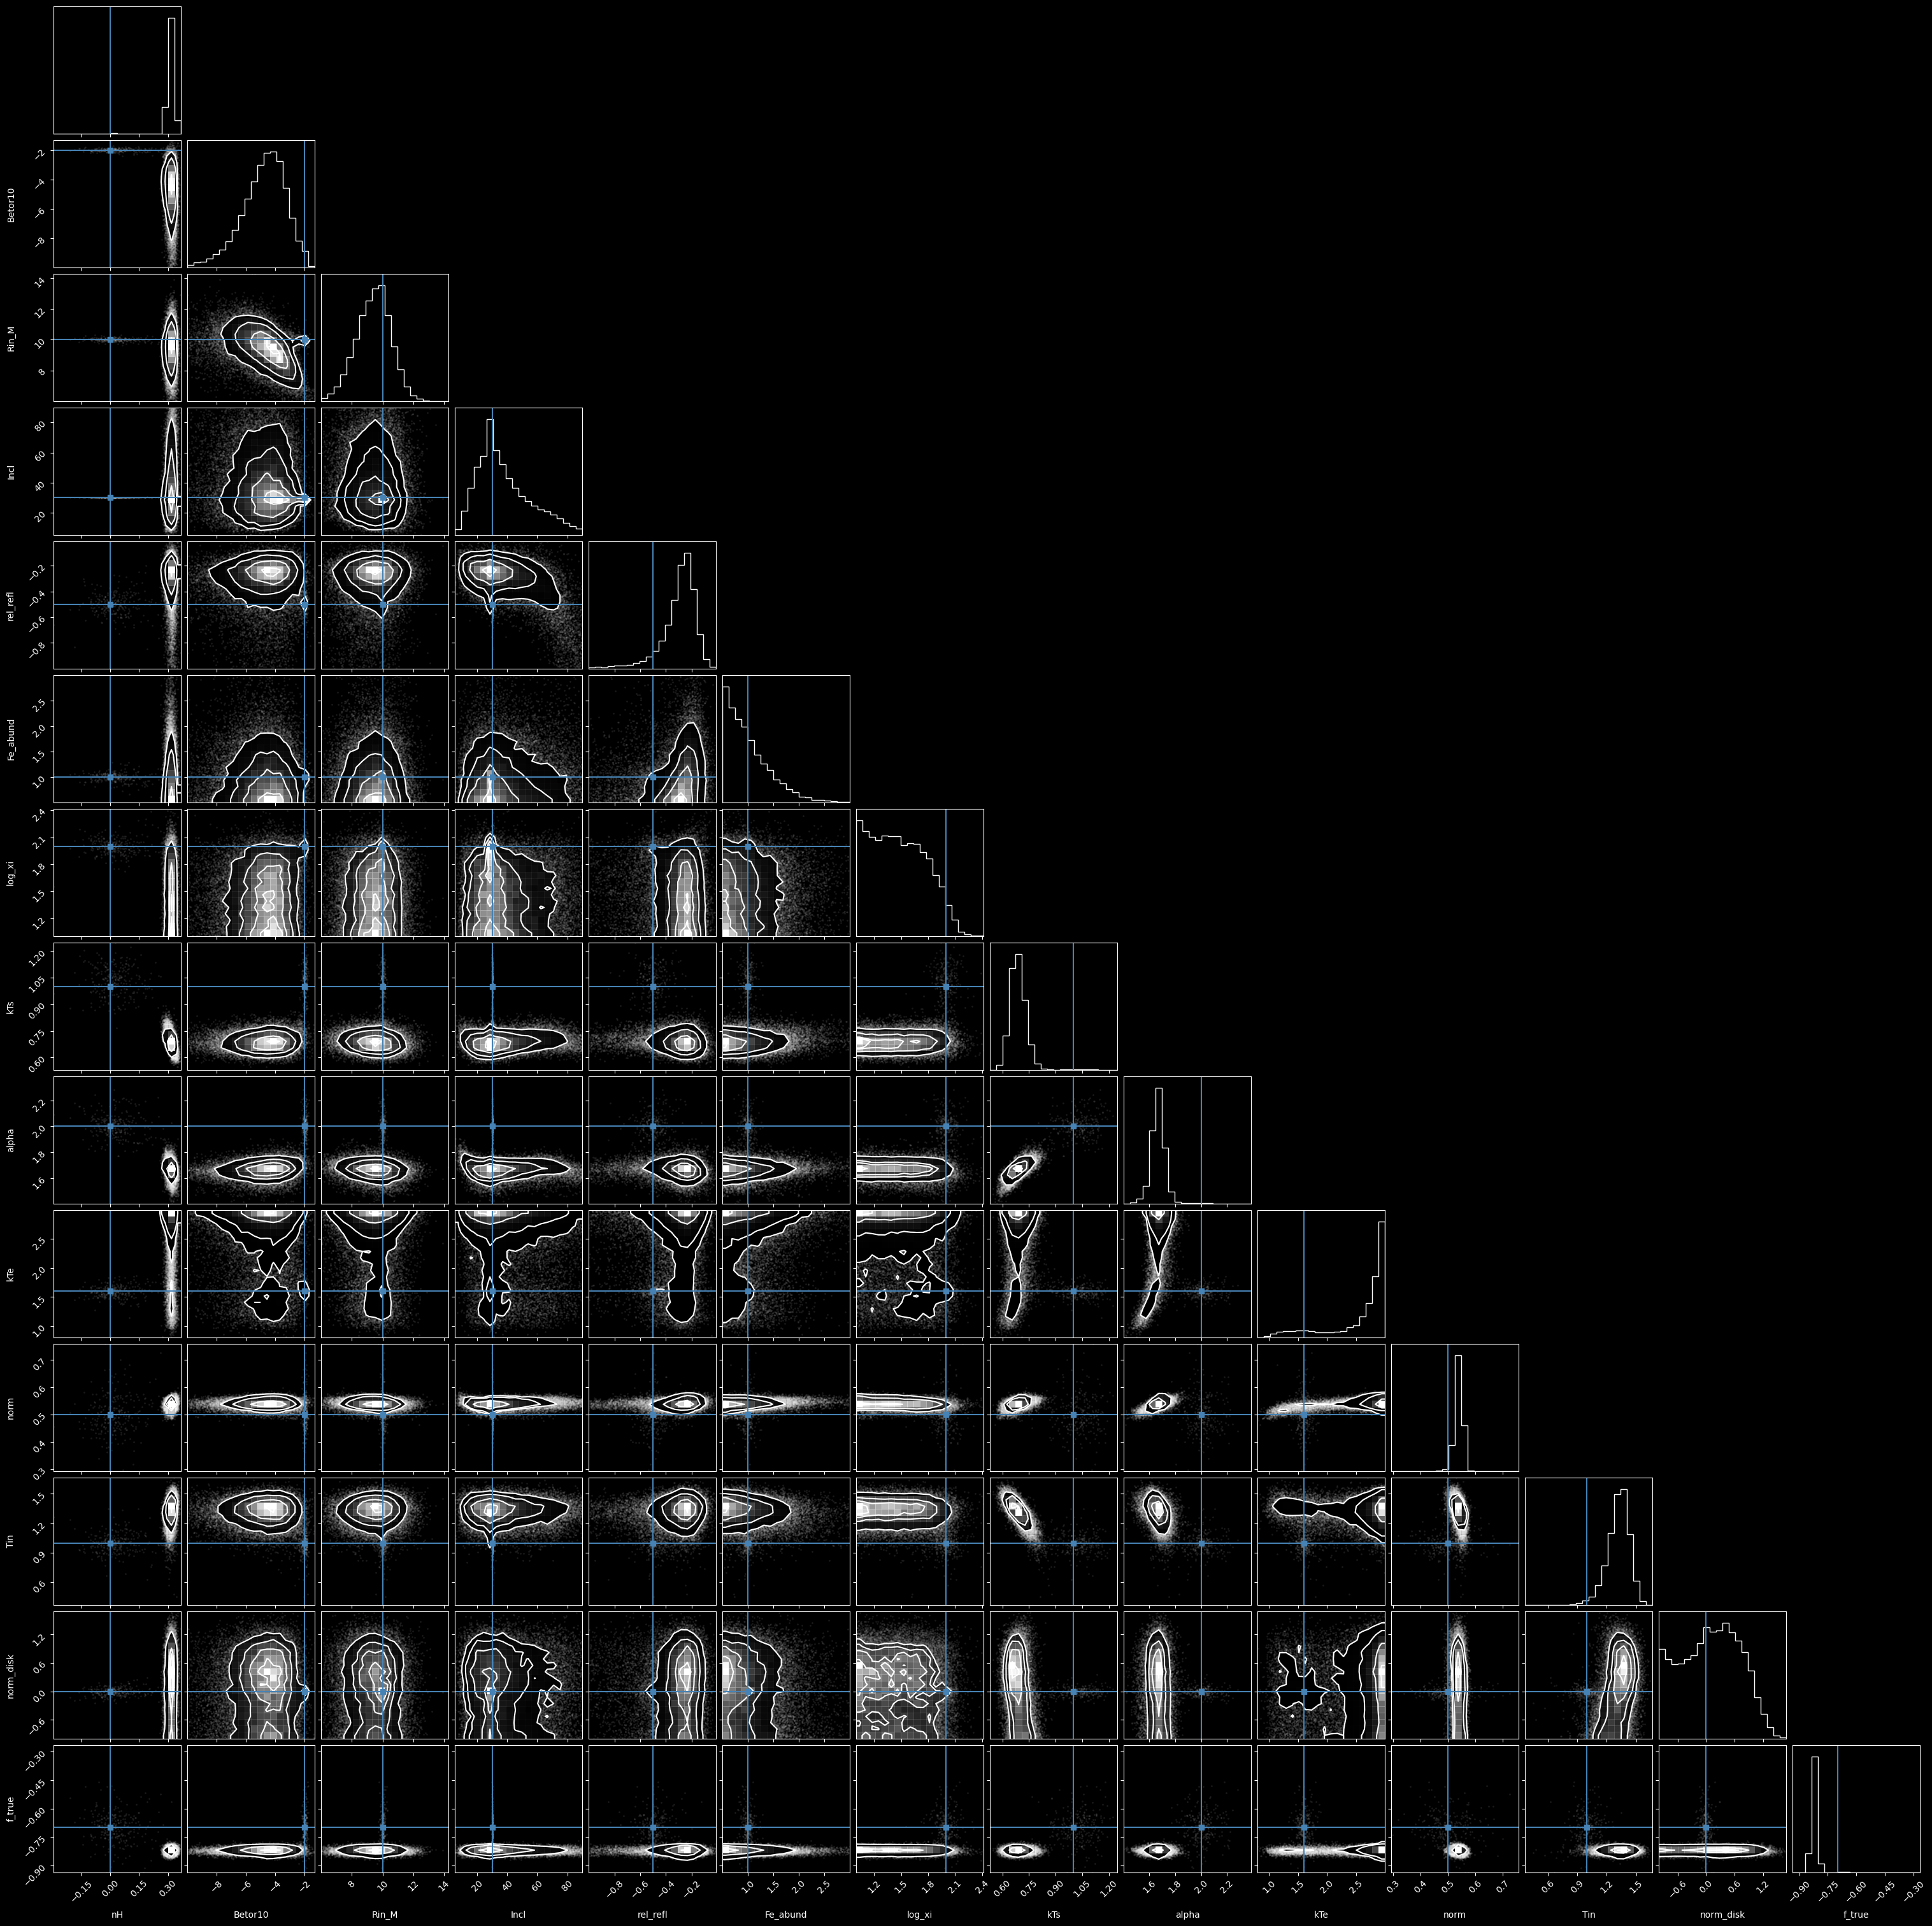

In [11]:
reader = emcee.backends.HDFBackend(mcmc_path / filename)

tau = reader.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
#burnin = 50
thin = int(0.5 * np.min(tau))
#thin = 2
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, 
     log_prob_samples[:, None], 
     log_prior_samples[:, None]
     ), 
    axis=1
)

names = [name for name in params.__dict__]
labels = names[:-1]
#labels += ["log prob", "log prior"]

fig = corner.corner(
    samples, labels=labels, truths=par_original,
)

In [12]:
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
print("True values:")
print(params)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

True values:
Parameters(
nH=0.0
Betor10=-2
Rin_M=10
Incl=30
rel_refl=-0.5
Fe_abund=1
log_xi=2
kTs=1
alpha=2
kTe=1.6020599913279625
norm=0.5
Tin=1
norm_disk=0.0
f_true=-0.6989700043360187
)


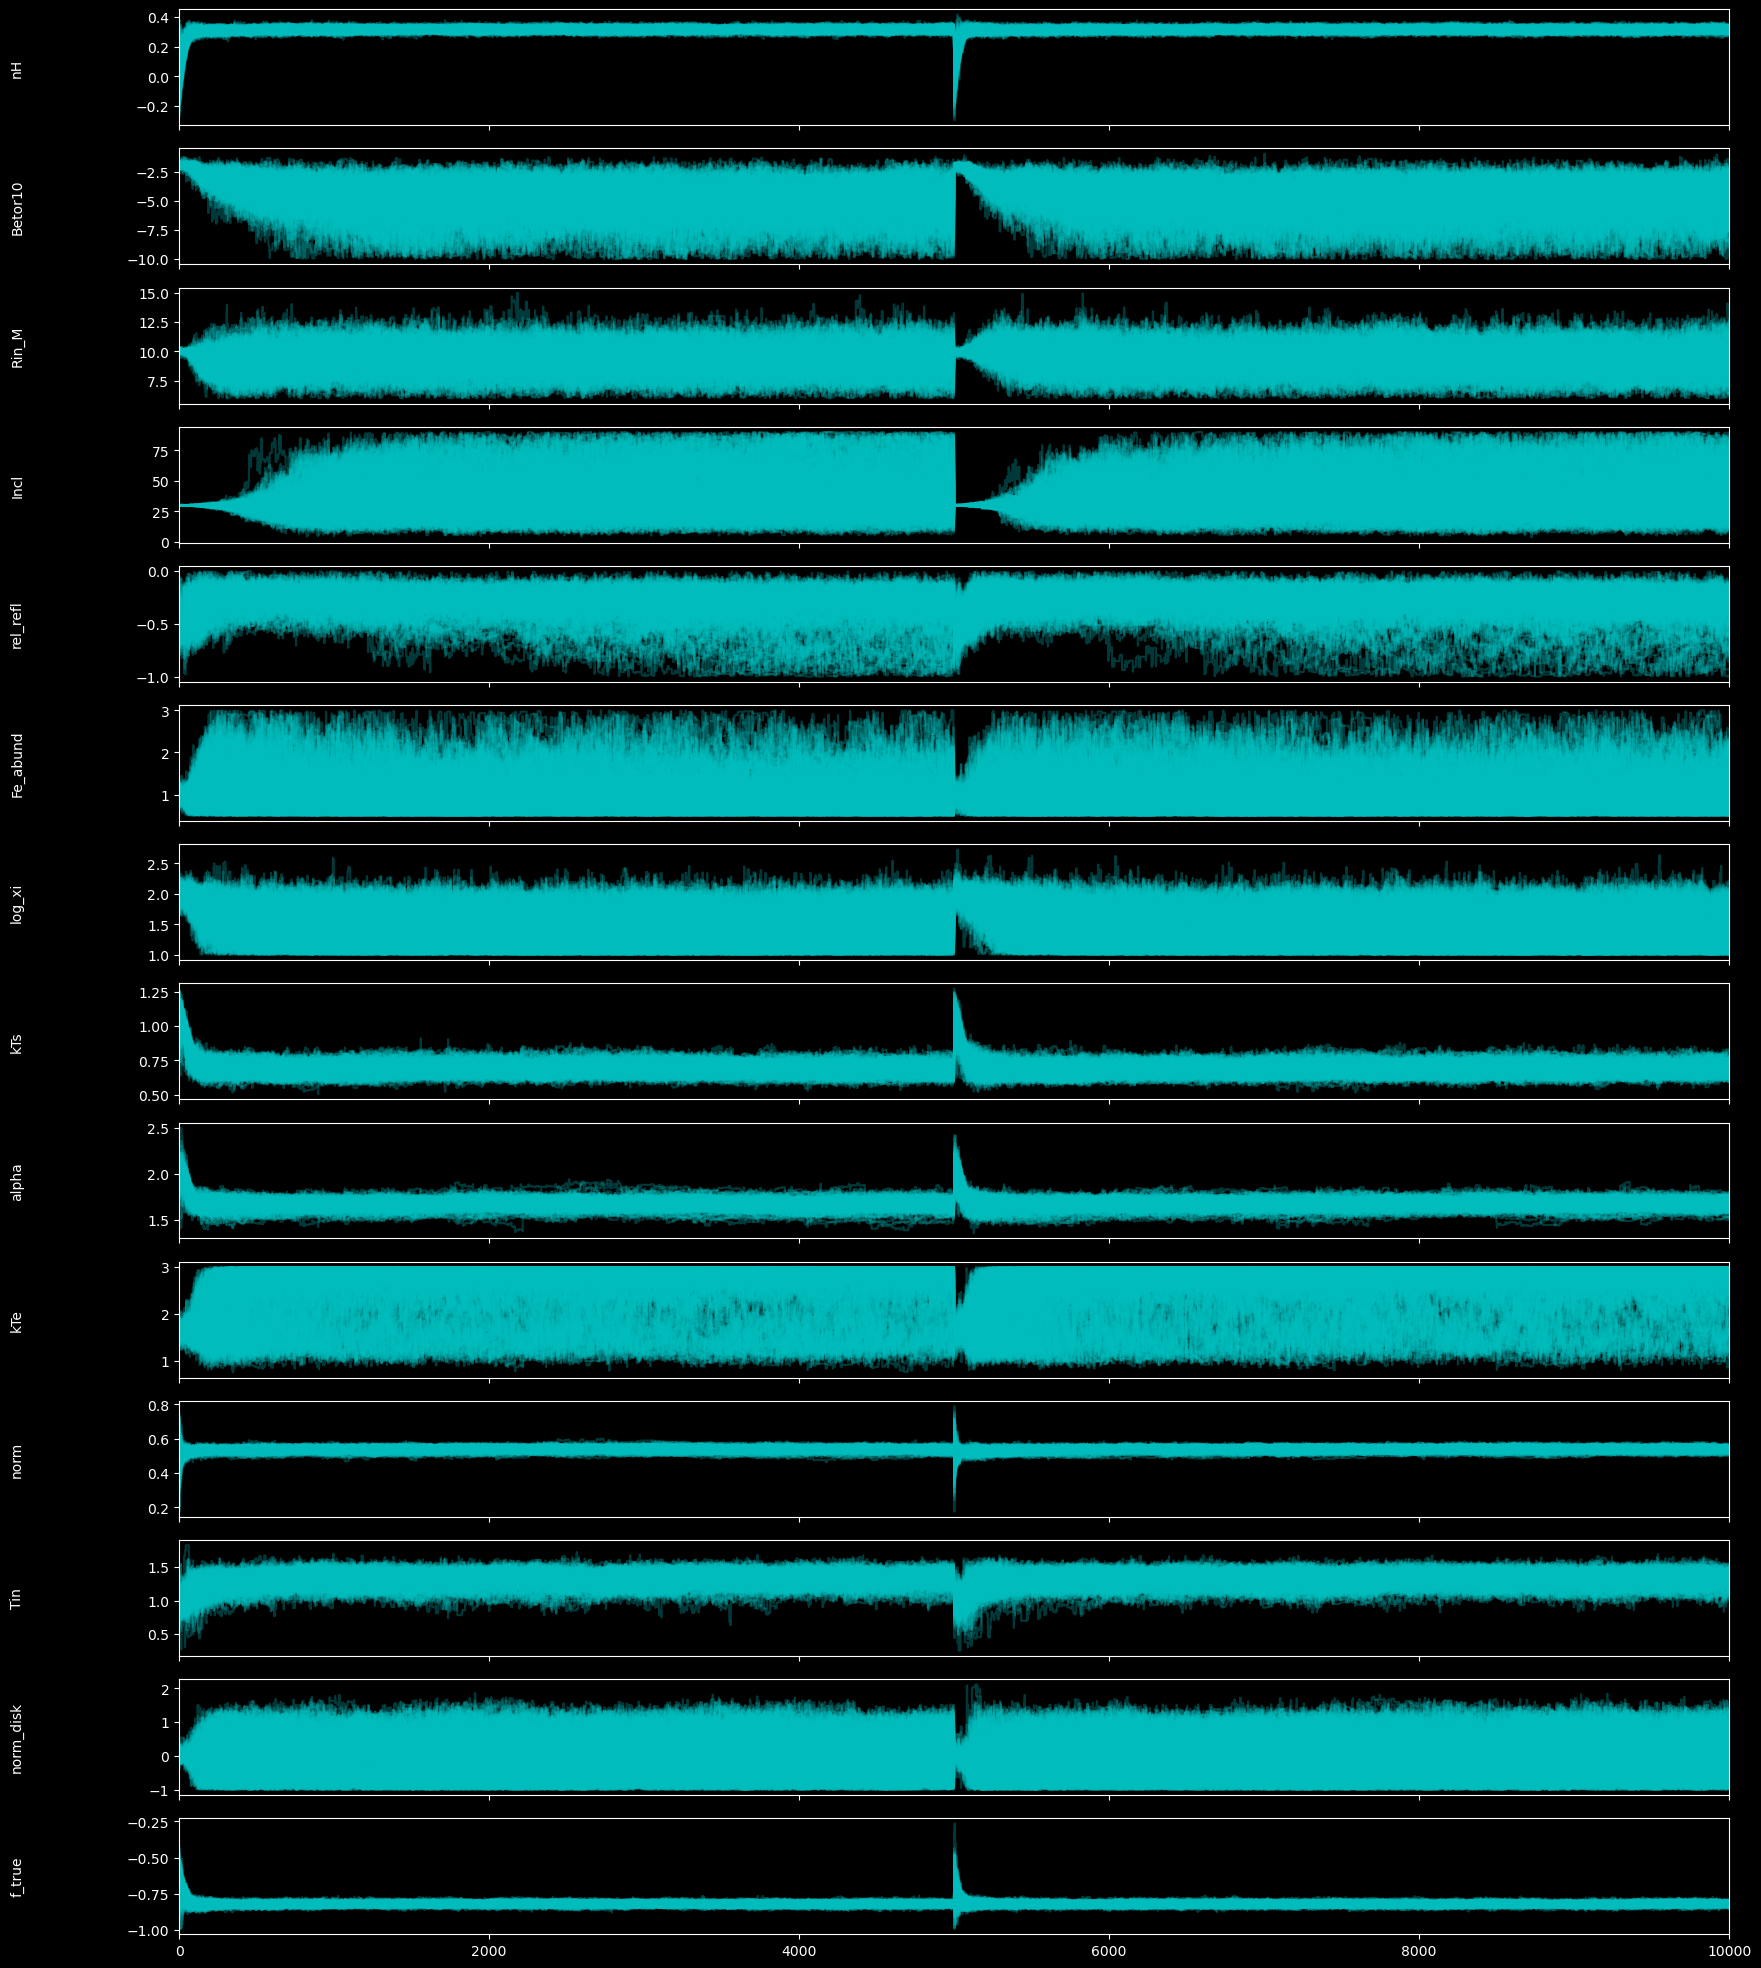

In [13]:
smpl = reader.get_chain()
fig, axes = plt.subplots(ndim, figsize=(20, 25), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(smpl[:, :, i], "c", alpha=0.3)
    ax.set_xlim(0, len(smpl))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
plt.show()

In [ ]:
new_backend = emcee.backends.HDFBackend(mcmc_path/filename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, backend=new_backend
)
new_sampler.run_mcmc(None, 100, progress=True)
print("Final size: {0}".format(new_backend.iteration))

Initial size: 2000


  0%|          | 0/100 [00:00<?, ?it/s]/home/antonio/Installed/anaconda3/envs/tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/antonio/Installed/anaconda3/envs/tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/antonio/Installed/anaconda3/envs/tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/antonio/Installed/anaconda3/envs/tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/home/antonio/Installed/anaconda3/envs/tf/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpd

Final size: 2100
